In [1]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import pickle
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [2]:
cls_cov = sacc.Sacc.load_fits('data/cls_cov.fits')
ls, cld, cov = cls_cov.get_ell_cl('cl_0e','ROSAT', 'DESY1wl__2', return_cov=True)
err = np.sqrt(np.diagonal(cov))

## Initialising defaults and tracers

In [3]:
cosmo = ccl.CosmologyVanillaLCDM()
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

zs = cls_cov.tracers['DESY1wl__2'].z
nz = cls_cov.tracers['DESY1wl__2'].nz

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

## Calculating the X-ray Spectrum

In [4]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

if os.path.isfile("data/Jtot.pck"):
    with open("data/Jtot.pck", "rb") as f:
        J_tot = pickle.load(f)
else:
    rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
    J_tot = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax)
    with open("data/Jtot.pck", "wb") as f:
        pickle.dump(J_tot, f)
if os.path.isfile("data/Jcont.pck"):
    with open("data/Jcont.pck", "rb") as f:
        J_cont = pickle.load(f)
else:
    rosat_spectrum = rx.ROSATResponse('data/pspcc_gain1_256.rsp')
    J_cont = rosat_spectrum.get_integrated_spectrum_interp(kTmin, kTmax, nkT, zmax, nz, emin, emax,
                                                           dolines=False, dopseudo=False)
    with open("data/Jcont.pck", "wb") as f:
        pickle.dump(J_cont, f)

## Calculating the X-ray profiles

In [23]:
a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1e14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

# Battaglia

pressure_bg = rx.HaloProfilePressureBattaglia(mass_def=mdef, kind='n_total')
density_bg = rx.HaloProfileDensityBattaglia(mass_def=mdef, kind='n_total')
xtot_bg = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                             dens=density_bg, pres=pressure_bg, fourier_approx=False)
x_bg = xtot_bg.real(cosmo, r, M, a)


# Hydrostatic Equilibirum
density_he = rx.HaloProfileDensityHE(mass_def=mdef, concentration=cM,
                                     kind='n_total')
pressure_he = rx.HaloProfilePressureHE(mass_def=mdef, concentration=cM,
                                       kind='n_total')
xtot_he = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                             dens=density_he, pres=pressure_he, fourier_approx=False)
x_he = xtot_he.real(cosmo, r, M, a)

# NFW
density_nfw = rx.HaloProfileDensityNFW(mass_def=mdef, concentration=cM,
                                       kind='n_total')
pressure_nfw = rx.HaloProfilePressureNFW(mass_def=mdef, concentration=cM,
                                         kind='n_total')
xtot_nfw = rx.HaloProfileXray(mass_def=mdef, Jinterp=J_tot,
                              dens=density_nfw, pres=pressure_nfw, fourier_approx=False, plaw_fourier=-2.7)
x_nfw = xtot_nfw.real(cosmo, r, M, a)

## Calculating the $P(k)$s and $C_\ell$s

In [24]:
k_arr = np.geomspace(1e-4, 20, 256)
a_arr = np.linspace(0.3,1,8)

In [25]:
pk_he = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, a_arr, dmat, prof2=xtot_he)

In [26]:
pk_bg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, a_arr, dmat, prof2=xtot_bg)

In [27]:
pk_nfw = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, a_arr, dmat, prof2=xtot_nfw)

[]

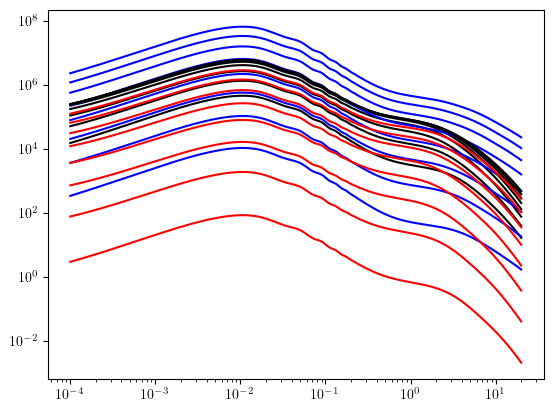

In [28]:
for ia, a in enumerate(a_arr):
    plt.plot(k_arr, pk_bg[ia], 'k-')
    plt.plot(k_arr, pk_he[ia], 'r-')
    plt.plot(k_arr, pk_nfw[ia], 'b-')
plt.loglog()

In [6]:
k_arr = np.geomspace(1e-4,1e2,256)
a_arr = np.linspace(0.3,1,8)

ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

# Battaglia
pk_bg = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               normprof1=True, prof2=xtot_bg, normprof2=False,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_bg = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_bg)

# Hydrostatic Equilibirum
pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               normprof1=True, prof2=xtot_he, normprof2=False,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_he = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)

# NFW
pk_nfw = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat,
                               normprof1=True, prof2=xtot_nfw, normprof2=False,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_nfw = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_nfw)

/Users/ferreirat/Library/CloudStorage/OneDrive-Personal/Player1/Codes/Xray/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:914: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(
/Users/ferreirat/Library/CloudStorage/OneDrive-Personal/Player1/Codes/Xray/xCell-likelihoods/papers/ROSATx/rosatX/profiles.py:928: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (sin

### Correcting for the smoothing

In [7]:
def pixel_FWHM(nside):
    """
    Returns the FWHM of the HEALPix pixel with nside = nside
    """
    fwhm_hp_amin =  60 * 41.7 / nside
    return np.radians(fwhm_hp_amin/60)/2.355

sigma_ROSAT = np.radians(1.8e0/60)/2.355
sigma_HEALPix = pixel_FWHM(1024)

sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_HEALPix**2

def cl_smoothing_factor(ell):
    return np.exp(-0.5*sigma_tot_2*ell*(1+ell))

cl_bg *= cl_smoothing_factor(ls)
cl_he *= cl_smoothing_factor(ls)
cl_nfw *= cl_smoothing_factor(ls)

## Plots

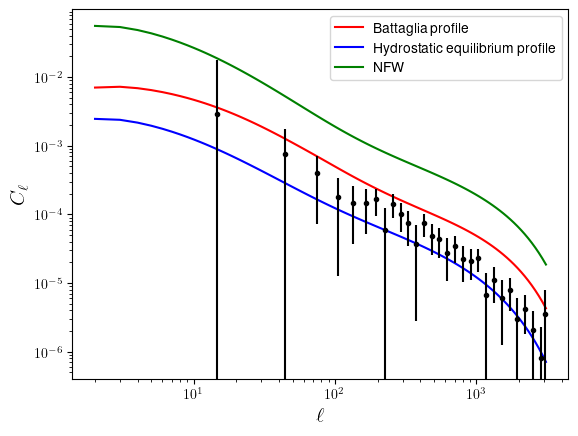

In [8]:
plt.plot(ls, cl_bg, 'r', label='Battaglia profile')
plt.plot(ls, cl_he, 'b', label='Hydrostatic equilibrium profile')
plt.plot(ls, cl_nfw, 'g', label='NFW')
plt.errorbar(ROSAT, DESY1wl__2, yerr=err, fmt='k.')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)

plt.legend();

plt.savefig('Plots/Cls_Comparison.pdf');